In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from model.rooms_problem import RoomsProblem
from model.rooms_agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent

from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np
# this is the context: goal function thing, 
sucessor_function = {
    0: {"A": 1, "B": 0, "C": 0},
    1: {"A": 2, "B": 0, "C": 0},
    2: {"A": 3, "B": 0, "C": 0},
    3: {"A": 4, "B": 0, "C": 0},
    4: {"A": 5, "B": 0, "C": 0},
    5: {"A": None, "B": 0, "C": 0}, # signifies the end!
}

reward_function = {
    0: {"A": 1, "B": 0, "C": 0},
    1: {"A": 1, "B": 0, "C": 0},
    2: {"A": 1, "B": 0, "C": 0},
    3: {"A": 1, "B": 0, "C": 0},
    4: {"A": 1, "B": 0, "C": 0},
    5: {"A": 1, "B": 0, "C": 0},
}

mappings = {
    0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
    1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
    2: {1: u'left', 0: u'up', 3: u'right', 2: u'down'},
    3: {5: u'up', 4: u'left', 7: u'down', 6: u'right'},
}

room_mappings = {
    0: mappings[0],
    1: mappings[0],
    2: mappings[1],
    3: mappings[1],
    4: mappings[2],
    5: mappings[2],
}

grid_world_size = (6, 6)

# make it easy, have the door and start locations be the same for each room
start_location = {r: (0,0) for r in range(9)}

# make it easy, each door is in the same spot
door_locations = {r: {'A':(5, 5), 'B':(5, 0), 'C':(0, 5)} for r in range(9)}

In [3]:
n_sims = 150

generate_kwargs = {
    'prunning_threshold': 10.0,
    'evaluate': False,
}

alpha = 1.0
inv_temp = 5.0


rooms_args = list([room_mappings, sucessor_function, reward_function, start_location,
                  door_locations])


def sim_task(rooms_args, desc='Running Task'):

    results = []
    for ii in tqdm(range(n_sims), desc=desc):

        rooms_kwargs = dict()
        
        task = RoomsProblem(*rooms_args, **rooms_kwargs)
        agent = IndependentClusterAgent(task, alpha=alpha, inv_temp=inv_temp)
        results_ic = agent.navigate_rooms(**generate_kwargs)
        results_ic[u'Model'] = 'Independent'
        results_ic['Iteration'] = [ii] * len(results_ic)

        task = RoomsProblem(*rooms_args, **rooms_kwargs)
        agent = JointClusteringAgent(task, alpha=alpha, inv_temp=inv_temp)
        results_jc = agent.navigate_rooms(**generate_kwargs)
        results_jc[u'Model'] = 'Joint'
        results_jc['Iteration'] = [ii] * len(results_jc)

        task = RoomsProblem(*rooms_args, **rooms_kwargs)
        agent = FlatAgent(task, inv_temp=inv_temp)
        results_fl = agent.navigate_rooms(**generate_kwargs)
        results_fl[u'Model'] = 'Flat'
        results_fl['Iteration'] = [ii] * len(results_fl)

        results.append(results_ic)
        results.append(results_jc)
        results.append(results_fl)
    return pd.concat(results)


results = sim_task(rooms_args)

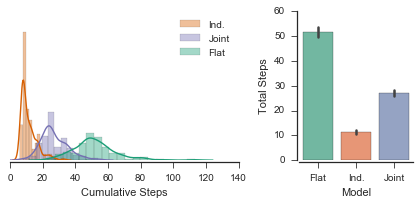

In [19]:
sns.set_context('paper', font_scale=1.25)
X0 = results[results['In Goal']].groupby(['Model', 'Iteration']).sum()
from matplotlib import gridspec

with sns.axes_style('ticks'):
    cc = sns.color_palette('Dark2')
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.0, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    sns.distplot(X0.loc['Independent']['Step'], label='Ind.', ax=ax0, color=cc[1])
    sns.distplot(X0.loc['Joint']['Step'], label='Joint', ax=ax0, color=cc[2])
    sns.distplot(X0.loc['Flat']['Step'], label='Flat', ax=ax0, color=cc[0])
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels)
    ax0.set_yticks([])
#     ax0.set_ylabel('Density')
    ax0.set_xlim([0, ax0.get_xlim()[1] ])
    ax0.set_xlabel('Cumulative Steps')
#     ax0.set_xticks(np.arange(0, 1501, 500))
    
    X1 = pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                X0.loc['Joint']['Step'].values,
                X0.loc['Independent']['Step'].values,
                X0.loc['Flat']['Step'].values, 
            ]),
        'Model': ['Joint'] * n_sims + ['Independent'] * n_sims + ['Flat'] * n_sims,
    })
    sns.barplot(data=X1, x='Model', y='Cumulative Steps Taken', ax=ax1, 
                palette='Set2', estimator=np.mean, order=['Flat', 'Independent', 'Joint'])
    ax1.set_ylabel('Total Steps')
    ax1.set_xticklabels(['Flat', 'Ind.', 'Joint'])
#     a
    sns.despine(offset=2)    
    ax0.spines['left'].set_visible(False)

    plt.tight_layout()
    fig.savefig('RoomsResults.png', dpi=300)

In [17]:
X1.groupby("Model").mean() / np.min(X1.groupby("Model").mean())

,Cumulative Steps Taken
Model,
Flat,4.536614
Independent,2.368483
Joint,1.000000


In [20]:
4.536614 / 2.368483


1.9154091458541185